Extracted Metadata: {'Mw': 6.07, 'Rake': -172, 'DIP': 82.0, 'HypZ': 10.0}
       LAT       LON    SLIP
0  38.3242 -122.3572  0.3350
1  38.3181 -122.3536  0.5755
2  38.3120 -122.3500  0.8581
3  38.3058 -122.3464  1.1141
4  38.2997 -122.3427  1.2896
Mean Absolute Error: 0.3302


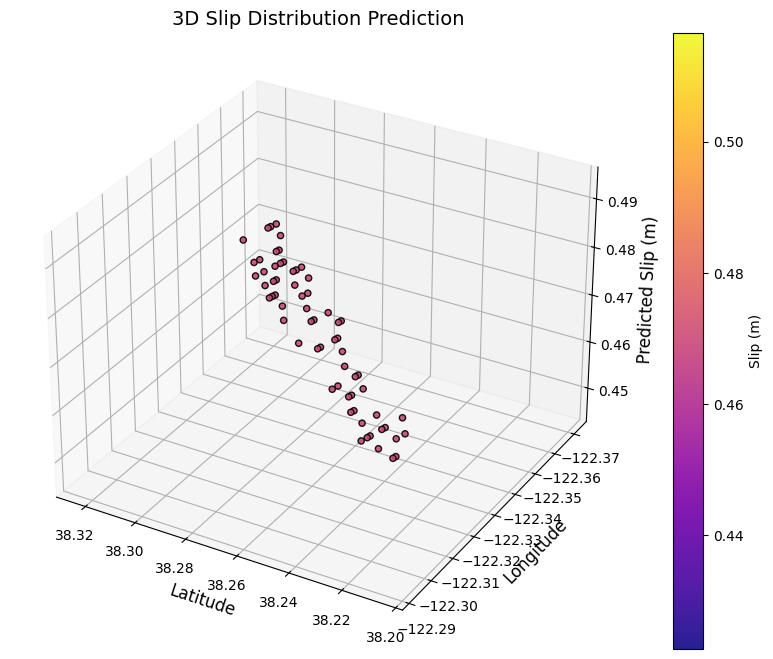

In [28]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# ✅ UPDATE FILE PATH AS NEEDED
file_path = r"C:\Users\ASUS\OneDrive\Desktop\SDA\week 3\srcmod2024-12-02FSP\s20142014SO01GALL.fsp"

# Read file
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Extract metadata
event_metadata = {}
source_model_data = []
slip_data_section = False

for line in lines:
    line = line.strip()

    # Extract Mw, HypZ, Rake, DIP
    for key, pattern in {"Mw": r'Mw\s*=\s*([\d.]+)', 
                         "HypZ": r'HypZ\s*=\s*([\d.]+)', 
                         "Rake": r'RAKE\s*=\s*([-]?\d+)', 
                         "DIP": r'DIP\s*=\s*([\d.]+)'}.items():
        match = re.search(pattern, line)
        if match:
            event_metadata[key] = float(match.group(1)) if key != "Rake" else int(match.group(1))

    # Identify slip data start
    if line.startswith("%") and "LAT" in line and "LON" in line and "SLIP" in line:
        slip_data_section = True
        continue

    # Extract slip data
    if slip_data_section and not line.startswith("%"):
        values = line.split()
        if len(values) >= 6:  # Ensure sufficient columns
            try:
                lat, lon, slip = float(values[0]), float(values[1]), float(values[5])
                source_model_data.append([lat, lon, slip])
            except ValueError:
                continue  # Skip malformed lines

# ✅ Ensure metadata is fully extracted
required_keys = ['Mw', 'HypZ', 'Rake', 'DIP']
if not all(key in event_metadata for key in required_keys):
    raise ValueError(f"Missing metadata fields! Required: {required_keys}, Found: {list(event_metadata.keys())}")

print("Extracted Metadata:", event_metadata)

# Convert data to DataFrame
df = pd.DataFrame(source_model_data, columns=['LAT', 'LON', 'SLIP'])
if df.empty:
    raise ValueError("No slip data extracted! Check the file formatting.")

print(df.head())

# Prepare features & target variables
X = np.array([[event_metadata['Mw'], event_metadata['HypZ'], event_metadata['Rake'], event_metadata['DIP']]] * len(df))
y = df['SLIP'].values

# ✅ Train-Test Split (Keep Spatial Structure)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_train, df_test = train_test_split(df[['LAT', 'LON']], test_size=0.2, random_state=42)

# Extract lat_test & lon_test separately
lat_test, lon_test = df_test['LAT'].values, df_test['LON'].values

# ✅ Train Model
model = RandomForestRegressor(n_estimators=200, random_state=42)  # Increased trees for better accuracy
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae:.4f}")

# ✅ Improved 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(lat_test, lon_test, predictions, c=predictions, cmap='plasma', edgecolors='k', alpha=0.9)
ax.set_xlabel("Latitude", fontsize=12)
ax.set_ylabel("Longitude", fontsize=12)
ax.set_zlabel("Predicted Slip (m)", fontsize=12)
ax.set_title("3D Slip Distribution Prediction", fontsize=14)

# Adjust viewing angle
ax.view_init(elev=30, azim=120)  # Rotate for better perspective
plt.colorbar(sc, label="Slip (m)")
plt.show()
